In [57]:
from google.colab import files
uploaded = files.upload()


Saving tab_aml_polars_version_fourtynine.py to tab_aml_polars_version_fourtynine.py


In [58]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
from tab_aml_polars_version_fourtynine import  find_optimal_threshold, FocalLoss, fast_hash, collate_encoded_batch, TabAMLDataset, TabAMLModel, train_epoch, evaluate,  build_weighted_sampler
import os, sys
import polars as pl
from datetime import timedelta
import torch
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn
from sklearn.metrics import (roc_auc_score, precision_recall_curve, auc as auc_metric,recall_score, precision_score, f1_score, confusion_matrix,)
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR


In [60]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [61]:
df = pl.read_csv("/content/drive/MyDrive/AML_Data/SAML-D.csv")
df.head()


Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
str,str,i64,i64,f64,str,str,str,str,str,i64,str
"""10:35:19""","""2022-10-07""",8724731955,2769355426,1459.15,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,"""Normal_Cash_Deposits"""
"""10:35:20""","""2022-10-07""",1491989064,8401255335,6019.64,"""UK pounds""","""Dirham""","""UK""","""UAE""","""Cross-border""",0,"""Normal_Fan_Out"""
"""10:35:20""","""2022-10-07""",287305149,4404767002,14328.44,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cheque""",0,"""Normal_Small_Fan_Out"""
"""10:35:21""","""2022-10-07""",5376652437,9600420220,11895.0,"""UK pounds""","""UK pounds""","""UK""","""UK""","""ACH""",0,"""Normal_Fan_In"""
"""10:35:21""","""2022-10-07""",9614186178,3803336972,115.25,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,"""Normal_Cash_Deposits"""


In [62]:
drive_path = '/content/drive/MyDrive/Colab Notebooks/'

In [63]:
df_train = pl.read_parquet(os.path.join(drive_path, "df_train.parquet"))
df_val = pl.read_parquet(os.path.join(drive_path, "df_val.parquet"))

In [65]:
df_test = pl.read_parquet(os.path.join(drive_path, "df_test.parquet"))

In [66]:
print(df_train)

shape: (7_429_619, 39)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Time     ┆ Date      ┆ Sender_ac ┆ Receiver_ ┆ … ┆ weekly_re ┆ daily_sen ┆ weekly_se ┆ circular_ │
│ ---      ┆ ---       ┆ count     ┆ account   ┆   ┆ ceiver_tr ┆ der_trans ┆ nder_tran ┆ transacti │
│ time     ┆ date      ┆ ---       ┆ ---       ┆   ┆ ansaction ┆ action    ┆ saction   ┆ on_count  │
│          ┆           ┆ i64       ┆ i64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆           ┆           ┆           ┆   ┆ i16       ┆ i16       ┆ i16       ┆ i8        │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 10:35:34 ┆ 2022-10-0 ┆ 560602477 ┆ 864619375 ┆ … ┆ 1         ┆ 1         ┆ 1         ┆ 0         │
│          ┆ 7         ┆ 5         ┆ 9         ┆   ┆           ┆           ┆           ┆           │
│ 10:36:04 ┆ 2022-10-0 ┆ 200413348 ┆ 307981854 ┆ … ┆ 68        ┆ 11 

In [67]:
df_train = df_train.with_columns(
    (df_train["Date"].dt.weekday().is_in([5, 6])).cast(pl.Int8).alias("is_weekend")
)


In [68]:
df_val = df_val.with_columns([
    (df_val["Date"].dt.weekday().is_in([5, 6])).cast(pl.Int8).alias("is_weekend")
])


In [69]:
df_test = df_test.with_columns(
    (df_test["Date"].dt.weekday().is_in([5, 6])).cast(pl.Int8).alias("is_weekend")
)


In [70]:
print(len(df_train), len(df_val), len(df_test))

7429619 1044845 1030388


In [71]:
cat_cols = ["Sender_account", "currency_mismatch",	"cross_border",	"high_risk_sender",	"high_risk_receiver"	, "Receiver_account", "Payment_currency", "Received_currency", "Sender_bank_location",
            "Receiver_bank_location", "Payment_type", "day_of_month", "month", "day_of_week", "minute", "second", "hour", "day_of_year", "is_weekend"]

In [72]:
cont_cols = ["Amount", "fanin_30d",	"fanout_30d",	"daily_recieve",	"monthly_receive",	"monthly_send", "back_and_forth_transfers",	"daily_receive",	"amount_dispersion_std",	"fan_in_out_ratio"	,"fanin_intensity_ratio",	"sent_to_received_ratio_monthly"	,"daily_receiver_transaction",	"weekly_receiver_transaction",	"daily_sender_transaction",	"weekly_sender_transaction",	"circular_transaction_count"]

In [73]:
train_ds = TabAMLDataset(
    df_train, cat_cols, cont_cols, "Is_laundering",
    fit=True,
    hash_growth=1.25,
    hash_cap={"Sender_account": 262_144, "Receiver_account": 1_048_576}
)


In [74]:
val_ds = TabAMLDataset(
    df_val, cat_cols, cont_cols, "Is_laundering",
    encoders=train_ds.encoders,
    scaler=train_ds.scaler,
    fit=False,
    hash_bucket_sizes=train_ds.hash_bucket_sizes
)

In [75]:
test_ds = TabAMLDataset(
    df_test, cat_cols, cont_cols, "Is_laundering",
    encoders=train_ds.encoders,
    scaler=train_ds.scaler,
    fit=False,
    hash_bucket_sizes=train_ds.hash_bucket_sizes
)

In [76]:
print("Hash bucket sizes:", train_ds.hash_bucket_sizes)

Hash bucket sizes: {'Sender_account': 262144, 'Receiver_account': 1048576}


In [77]:
print("Unique Sender accounts:", df_train["Sender_account"].n_unique())
print("Unique Receiver accounts:", df_train["Receiver_account"].n_unique())

Unique Sender accounts: 245891
Unique Receiver accounts: 589380


In [78]:
train_sampler = build_weighted_sampler(pl.Series(df_train["Is_laundering"]), power = 0.7)

In [79]:
train_loader  = DataLoader(train_ds, batch_size=512, sampler=train_sampler, collate_fn=collate_encoded_batch)


In [80]:
val_loader   = DataLoader(val_ds, batch_size=512, shuffle=False, collate_fn=collate_encoded_batch)

In [81]:
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False, collate_fn=collate_encoded_batch)

In [82]:
model = TabAMLModel(category_sizes=train_ds.category_sizes, cont_dim=len(cont_cols), embedding_dim=48, shared_ratio=1/6, num_heads=4, num_layers1=2, num_layers2=2, dropout=0.25, micro_indices=(0, 1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TabAMLModel(
  (embs): ModuleList(
    (0): Embedding(262144, 40)
    (1-4): 4 x Embedding(3, 40)
    (5): Embedding(1048576, 40)
    (6-7): 2 x Embedding(14, 40)
    (8-9): 2 x Embedding(19, 40)
    (10): Embedding(8, 40)
    (11): Embedding(32, 40)
    (12): Embedding(10, 40)
    (13): Embedding(8, 40)
    (14-15): 2 x Embedding(61, 40)
    (16): Embedding(25, 40)
    (17): Embedding(251, 40)
    (18): Embedding(3, 40)
  )
  (micro): ResidualAttentionEncoder(
    (layers): ModuleList(
      (0-1): 2 x ResidualAttentionLayer(
        (qkv): Linear(in_features=48, out_features=144, bias=False)
        (attn_out): Linear(in_features=48, out_features=48, bias=False)
        (ffn): Sequential(
          (0): Linear(in_features=48, out_features=192, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.25, inplace=False)
          (3): Linear(in_features=192, out_features=48, bias=True)
          (4): Dropout(p=0.25, inplace=False)
        )
        (norm1): LayerNo

In [83]:
loss_fn = FocalLoss(alpha=0.75, gamma=2.0)

In [84]:
base_lr = 1e-3
warmup_steps = 50
epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=1e-4)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

global_step = 0  # track warm-up progress
best_val_auc_pr = 0


In [85]:
for epoch in range(1, epochs + 1):

    train_loss, global_step = train_epoch(
        model, train_loader, optimizer, loss_fn, device,
        warmup_steps, base_lr, global_step
    )

    val_loss, val_auc, val_auc_pr, val_rec, val_prec, val_f1, _ = evaluate(
        model, val_loader, loss_fn, device
    )

    cosine_scheduler.step()

    print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | ROC-AUC: {val_auc:.4f} | "
          f"PR-AUC: {val_auc_pr:.4f} | Recall: {val_rec:.3f} | "
          f"Precision: {val_prec:.3f} | F1: {val_f1:.3f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    if val_auc_pr > best_val_auc_pr:
        best_val_auc_pr = val_auc_pr
        torch.save(model.state_dict(), "best_tabaml_model.pt")
        print(f" Saved new best model (PR-AUC = {best_val_auc_pr:.4f})")

Streaming output truncated to the last 5000 lines.
[Warmup] Step 41300 | LR: 0.000956
[Warmup] Step 41350 | LR: 0.000956
[Warmup] Step 41400 | LR: 0.000956
[Warmup] Step 41450 | LR: 0.000956
[Warmup] Step 41500 | LR: 0.000956
[Warmup] Step 41550 | LR: 0.000956
[Warmup] Step 41600 | LR: 0.000956
[Warmup] Step 41650 | LR: 0.000956
[Warmup] Step 41700 | LR: 0.000956
[Warmup] Step 41750 | LR: 0.000956
[Warmup] Step 41800 | LR: 0.000956
[Warmup] Step 41850 | LR: 0.000956
[Warmup] Step 41900 | LR: 0.000956
[Warmup] Step 41950 | LR: 0.000956
[Warmup] Step 42000 | LR: 0.000956
[Warmup] Step 42050 | LR: 0.000956
[Warmup] Step 42100 | LR: 0.000956
[Warmup] Step 42150 | LR: 0.000956
[Warmup] Step 42200 | LR: 0.000956
[Warmup] Step 42250 | LR: 0.000956
[Warmup] Step 42300 | LR: 0.000956
[Warmup] Step 42350 | LR: 0.000956
[Warmup] Step 42400 | LR: 0.000956
[Warmup] Step 42450 | LR: 0.000956
[Warmup] Step 42500 | LR: 0.000956
[Warmup] Step 42550 | LR: 0.000956
[Warmup] Step 42600 | LR: 0.000956
[War

In [86]:
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        x_cat = batch.x_cat.to(device)
        x_cont = batch.x_cont.to(device)
        y = batch.y.to(device)

        logits = model(x_cat, x_cont)
        if logits.ndim > 1:
            logits = logits.squeeze(-1)  # handles [batch,1]
        probs = torch.sigmoid(logits).cpu().numpy()

        all_probs.append(probs)
        all_labels.append(y.cpu().numpy())


all_probs = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)


In [106]:
beta = 2  # recall-focused
best_thr, best_f2 = find_optimal_threshold(all_probs, all_labels, beta)

print("\nOptimal threshold found on validation:")
print(f"Threshold = {best_thr:.4f} | Best F2 = {best_f2:.4f}")



Optimal threshold found on validation:
Threshold = 0.0500 | Best F2 = 0.6019


In [107]:
test_all_probs = []
test_all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x_cat = batch.x_cat.to(device)
        x_cont = batch.x_cont.to(device)
        y = batch.y.to(device)

        logits = model(x_cat, x_cont)
        if logits.ndim > 1:
            logits = logits.squeeze(-1)

        probs = torch.sigmoid(logits).cpu().numpy()

        test_all_probs.append(probs)
        test_all_labels.append(y.cpu().numpy())

test_all_probs = np.concatenate(test_all_probs)
test_all_labels = np.concatenate(test_all_labels)

# Apply best threshold from validation
test_preds = (test_all_probs >= best_thr).astype(int)

In [108]:
prec1 = precision_score(test_all_labels, test_preds, pos_label=1)
rec1 = recall_score(test_all_labels, test_preds, pos_label=1)
f1_1 = f1_score(test_all_labels, test_preds, pos_label=1)

print(f"Class 1 Precision: {prec1:.4f}")
print(f"Class 1 Recall:    {rec1:.4f}")
print(f"Class 1 F1 Score:  {f1_1:.4f}")



Class 1 Precision: 0.8074
Class 1 Recall:    0.5317
Class 1 F1 Score:  0.6412


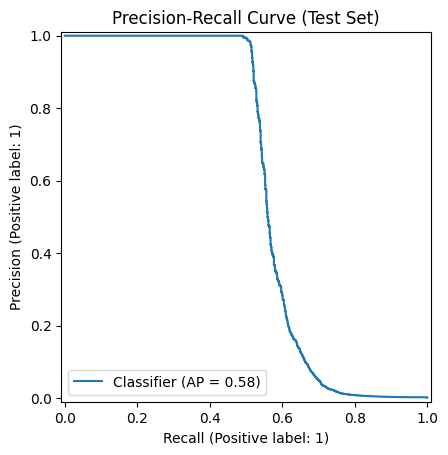

In [109]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x_cat = batch.x_cat.to(device)
        x_cont = batch.x_cont.to(device)
        y = batch.y.cpu().numpy()      # make sure labels are on CPU

        logits = model(x_cat, x_cont)
        if logits.ndim > 1:
            logits = logits.squeeze(-1)   # handle [batch, 1]

        probs = torch.sigmoid(logits).cpu().numpy()

        y_true.extend(y)
        y_pred.extend(probs)

prec, rec, thr = precision_recall_curve(y_true, y_pred)

disp = PrecisionRecallDisplay.from_predictions(y_true, y_pred)
disp.ax_.set_title("Precision-Recall Curve (Test Set)")
plt.show()



In [92]:
np.save("transformer_precision.npy", prec)
np.save("transformer_recall.npy", rec)
np.save("transformer_thresholds.npy", thr)


In [93]:
from google.colab import files
files.download("transformer_precision.npy")
files.download("transformer_recall.npy")
files.download("transformer_thresholds.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [94]:
torch.save(model, "best_tabaml_model_full.pth")


In [95]:
!ls -lh /content


total 422M
-rw-r--r-- 1 root root 202M Nov  8 22:42 best_tabaml_model_full.pth
-rw-r--r-- 1 root root 202M Nov  8 20:59 best_tabaml_model.pt
drwx------ 5 root root 4.0K Nov  8 20:00 drive
drwxr-xr-x 2 root root 4.0K Nov  8 20:00 __pycache__
drwxr-xr-x 1 root root 4.0K Nov  5 14:33 sample_data
-rw-r--r-- 1 root root  13K Nov  8 19:29 tab_aml_polars_version_fourtyeight.py
-rw-r--r-- 1 root root  13K Nov  8 20:00 tab_aml_polars_version_fourtynine.py
-rw-r--r-- 1 root root  13K Nov  8 19:05 tab_aml_polars_version_fourtyseven.py
-rw-r--r-- 1 root root 7.7M Nov  8 22:42 transformer_precision.npy
-rw-r--r-- 1 root root 7.7M Nov  8 22:42 transformer_recall.npy
-rw-r--r-- 1 root root 3.9M Nov  8 22:42 transformer_thresholds.npy


In [96]:
from google.colab import files
files.download("best_tabaml_model_full.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [97]:
from google.colab import drive
drive.mount('/content/drive')
!cp best_tabaml_model_full.pth /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
